[Kanitscheider + Fiete 2017 - "Emergence of dynamically reconfigurable hippocampal responses by learning to perform probabilistic spatial reasoning"](https://doi.org/10.1101/231159)

In [2]:
import torch
import random
from math import pi

def vonMises(x, sigma):
    """The PDF of a von Mises distribution centered on 0."""
    return torch.exp((torch.cos(x)-1)/(2*sigma**2))

def circular(theta):
    """Wraps `theta` to [-pi,pi)."""
    return (theta+pi)%(2*pi)-pi

def paddedRandomAngles(n, delta):
    """`n` random angles [-pi,pi) with `delta` minimum pairwise angular distance.

    Args:
        n (int): number of angles.
        delta (float): minimum pairwise angular distance, in radians.

    Returns:
        angles (Tensor): the list of angles.
    """
    angles = torch.tensor([])
    while len(angles)<n:
        potentialAngle = 2*pi*torch.rand(1)-pi
        if all(abs(circular(potentialAngle - angles)) > delta):
            angles = torch.cat((angles, potentialAngle))
    return angles

def randomWalk(steps, x0, vMax, aMax, aSigma):
    """Normally-distributed zero-mean acceleration with magnitude-
    clipped acceleration and velocity, starting at rest.
    
    Args:
        steps (int): duration of the walk, in time steps.
        x0 (float): initial position.
        vMax (float): maximum velocity, in radians/step.
        aMax (float): maximum acceleration, in radians/step^2.
        aSigma (float): standard deviation of acceleration, in radians/step^2.

    Returns:
        x (Tensor): position at each time step.
    """
    x = x0
    v = 0
    output = torch.zeros(steps)
    for step in range(steps):
        output[step] = x
        a = max(-aMax, min(aMax, random.gauss(0, aSigma)))
        v += a
        if v>vMax:
            v -= 2*(v-vMax)
        elif v<-vMax:
            v += 2*(v-vMax)
        v = max(-vMax, min(vMax, v))
        x += v
    return output

def createBatch(n_trials, n_steps, n_input, n_output):

    vMax = 2*pi/n_output
    aMax = vMax/2
    xSigma = vMax/2
    aSigma = vMax/10
    delta = 2*vMax
    dMin = vMax/2
    
    places = torch.linspace(-pi, pi*(1-2/n_output), n_output)
    landmarks = [paddedRandomAngles(random.randint(2, 4), delta) for _ in range(n_trials)]
    
    input = torch.zeros(n_trials, n_steps, n_input)
    target = torch.zeros(n_trials, n_steps, n_output)
    
    for trial in range(n_trials):
        x0 = random.random()*2*pi-pi
        for step, x in enumerate(circular(randomWalk(n_steps, x0, vMax, aMax, aSigma))):
            
            input[trial,step,:-n_output] = circular(x-x0) / vMax
            lmProximity = sum(vonMises(x-landmarks[trial], xSigma))
            input[trial,step,-n_output:] = lmProximity * sum(vonMises(lm-places, xSigma) for lm in landmarks[trial])
                
            target[trial,step,:] = vonMises(x-places, xSigma)
            
            x0 = x
    
    return (input, target, landmarks)

## Initialize.

In [49]:
class Network(torch.nn.Module):
    def __init__(self, n_input, n_hidden, n_output):
        super(Network, self).__init__()
        self.rnn = torch.nn.RNN(n_input, n_hidden, batch_first=True)
        self.linear = torch.nn.Linear(n_hidden, n_output)
        self.tanh = torch.nn.Tanh()

    def forward(self, input):
        return self.tanh(self.linear(self.rnn(input)[0]))

N_INPUT = 21
N_HIDDEN = 200
N_OUTPUT = 20

N_STEPS = 300
N_TRIALS = 1
N_BATCHES = 1000000

network = Network(N_INPUT, N_HIDDEN, N_OUTPUT)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(network.parameters())

## Train.

In [ ]:
for batch in range(N_BATCHES):
    
    input, target, landmarks = createBatch(N_TRIALS, N_STEPS, N_INPUT, N_OUTPUT)
    output = network(input)

    loss = criterion(output, target)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

## Visualize.

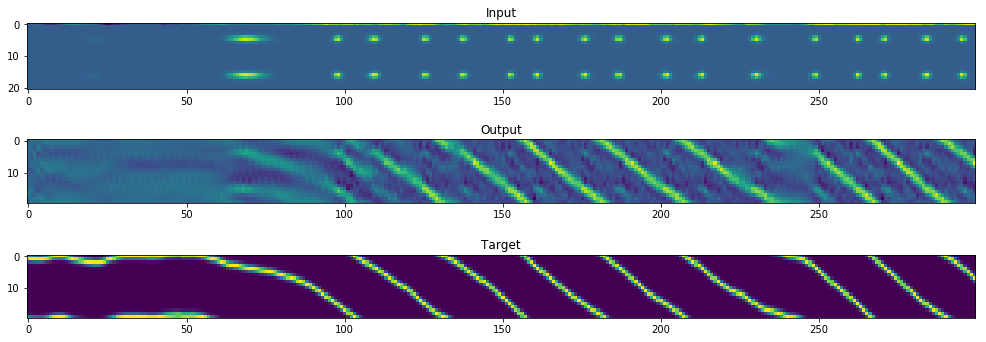

In [82]:
%matplotlib inline
import matplotlib.pyplot as plt

fig,ax = plt.subplots(3, figsize=(17,6))

input, target, landmarks = createBatch(1, N_STEPS, N_INPUT, N_OUTPUT)
output = network(input)
ax[0].imshow(input[0].data.numpy().T)
ax[0].set_title('Input')
ax[1].imshow(output[0].data.numpy().T)
ax[1].set_title('Output')
ax[2].imshow(target[0].data.numpy().T)
ax[2].set_title('Target')
plt.show()